# Подготовка данных или Feature [Preprocessing](https://neptune.ai/blog/data-preprocessing-guide)

Здесь мы рассмотрим несколько важных моментов связанных с подготовкой данных к обучению.

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
from setup_libs import *

# Feature Engineering (Создание новых признаков)

Под этим словосочетанием подразумевают создание и подготовку признаков объектов, чтобы они лучше подходили под алгоритмы и давали наилучший результат. Рассмотрим пример концентрических окружностей.

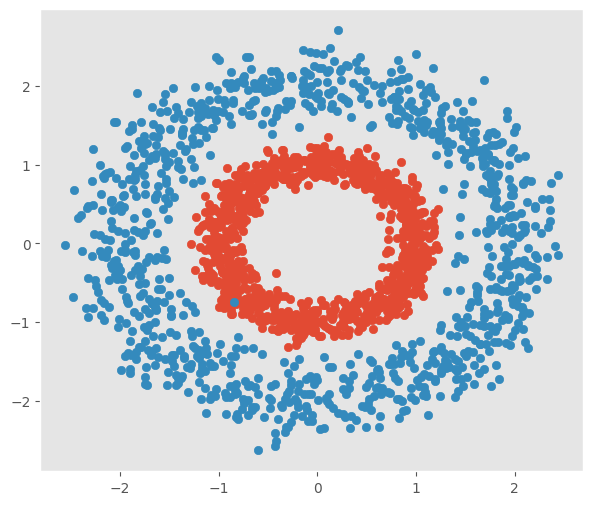

In [3]:
num_samples = 1000
theta = np.linspace(0, 2*np.pi, num_samples)

r1 = 1
r2 = 2

rng = np.random.RandomState(1)

circle = np.hstack([np.cos(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8), 
                    np.sin(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8)])
lil = r1 * circle
big = r2 * circle
X = np.vstack([lil, big])
y = np.hstack([np.zeros(num_samples), np.ones(num_samples)])

# plots
plt.figure(figsize=(7,6))
plt.scatter(lil[:,0],lil[:,1])
plt.scatter(big[:,0],big[:,1])
plt.grid()

Давайте попробуем классифицировать их деревом

In [4]:
from sklearn.tree import DecisionTreeClassifier as DTC
clf = DTC()
clf.fit(X, y)
clf.tree_.max_depth

9

DecisionTreeClassifier()

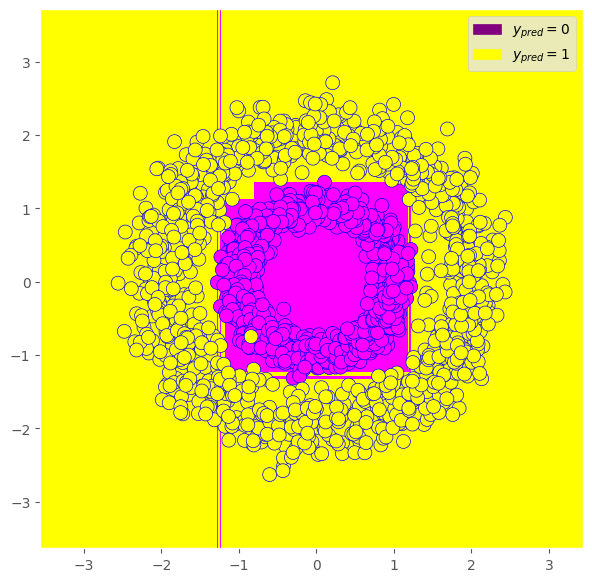

In [5]:
plot_model(X, y, clf)

Глубина дерева - 9, несмотря на такую простую с первого взгляда классификацию. Можно ли что-то с этим сделать?

А давайте добавим радиус в наши данные.

In [6]:
r = X[:,0]**2 + X[:,1]**2
X_new = np.hstack([X, r.reshape([-1,1])])

In [7]:
clf2 = DTC()
clf2.fit(X_new, y)
clf2.tree_.max_depth

3

In [8]:
cross_val_score(clf, X, y, cv=5, scoring=metrics._scorer.accuracy_scorer)

array([0.9925, 0.9875, 0.8975, 0.9875, 0.9875])

In [9]:
cross_val_score(clf, X_new, y, cv=5, scoring=metrics._scorer.accuracy_scorer)

array([1.    , 1.    , 0.9975, 0.9975, 1.    ])

Добавив логичный признак, который мы предположили, мы сумели классифицировать данные гораздо более простой моделью, да еще и с намного лучшим качеством. Этот процесс и называется `Feature Engineering`.

## Линейная Регрессия и Polynomial Features

Собственно, с помощью создания фич мы можем заставить работать линейную регрессию. Вернемся к примеру с прошлого семинара.

In [10]:
def plot_reg(X, y, clf_dtc, X_test, dim=0):
    clf_dtc.fit(X, y)
    Y_test = clf_dtc.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:,dim], y, cmap='bwr', s=50, alpha=1)
    plt.plot(X_test[:,dim], Y_test, color='r', alpha=1)
    plt.grid()

In [11]:
def f(x):
    return np.sqrt(x) + np.sin(x)

vf = np.vectorize(f)
rng = np.random.RandomState(1)

X_reg = np.arange(0, 10, 0.2)[:, np.newaxis]
y_reg = vf(X_reg) + (rng.rand(50)[:,np.newaxis] / 2)#добавляем шумы

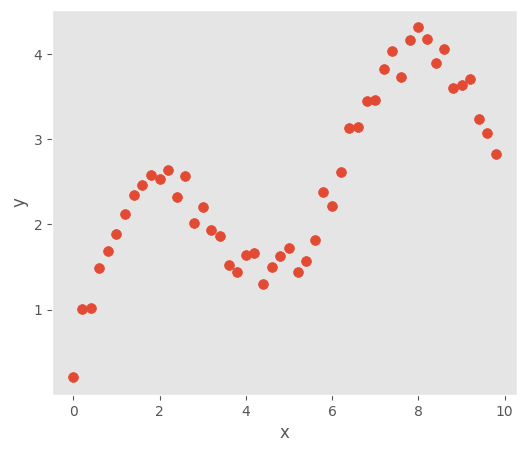

In [12]:
plt.figure(figsize=(6, 5))
plt.scatter(X_reg, y_reg, cmap='bwr', s=50, alpha=1)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

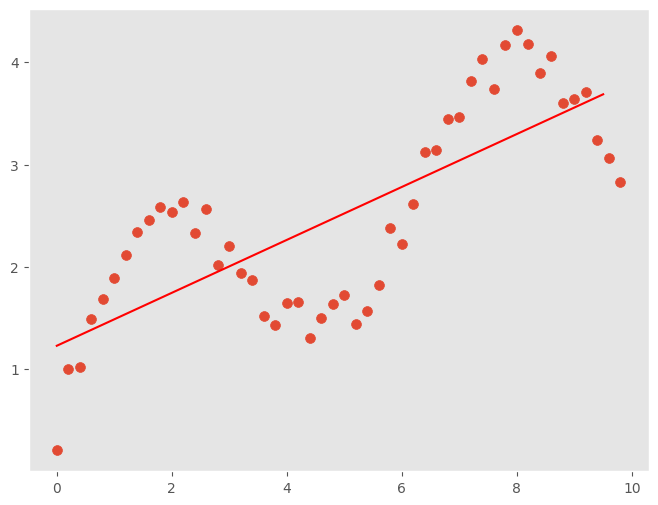

In [13]:
from sklearn.linear_model import LinearRegression as LR
reg_lr = LR()
X_test = np.arange(0, 10, 0.5)[:,np.newaxis]
plot_reg(X_reg, y_reg, reg_lr, X_test)

Теперь добавим функции второй, третей и четвертых степеней.

In [14]:
X_reg_new = np.hstack([X_reg, X_reg**2, X_reg**3, X_reg**4])
X_test_new = np.hstack([X_test, X_test**2, X_test**3, X_test**4])

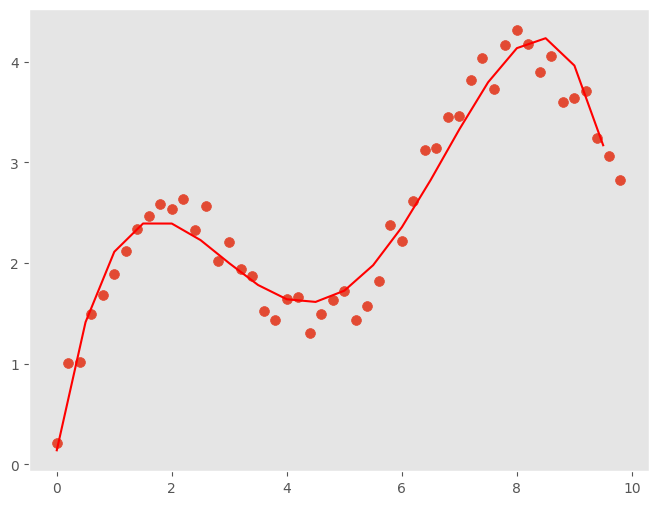

In [15]:
from sklearn.linear_model import LinearRegression as LR
reg_lr = LR()
plot_reg(X_reg_new, y_reg, reg_lr, X_test_new)

В изначальной линейной регрессии мы находимся в пространстве линейных алгоритмов:
$$a(x) = a_0x_0 + a_1x_1 + \ldots a_nx_n$$
    
Но теперь место фич у нас заняли полиномиальные функции и мы получили степенную функцию:

$$a(x) = a_0 + a_1x^1 + \ldots a_nx^n$$

Чтобы не делать это вручную, есть механизм `PolynomialFeatures`

In [16]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=8)

X_reg2 = poly.fit_transform(X_reg)
X_test2 = poly.fit_transform(X_test)

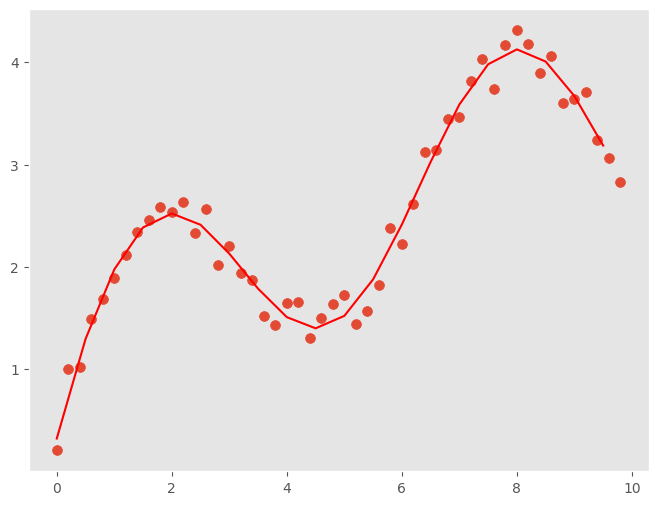

In [17]:
from sklearn.linear_model import LinearRegression as LR
reg_lr = LR()
plot_reg(X_reg2, y_reg, reg_lr, X_test2, dim=1)

С другой стороны мы можем догадаться, что тут не степенные функции и использовать те функции, которые нужны.

In [18]:
X_reg3 = np.hstack([X_reg, X_reg**0.5, np.sin(X_reg)])
X_test3 = np.hstack([X_test, X_test**0.5, np.sin(X_test)])

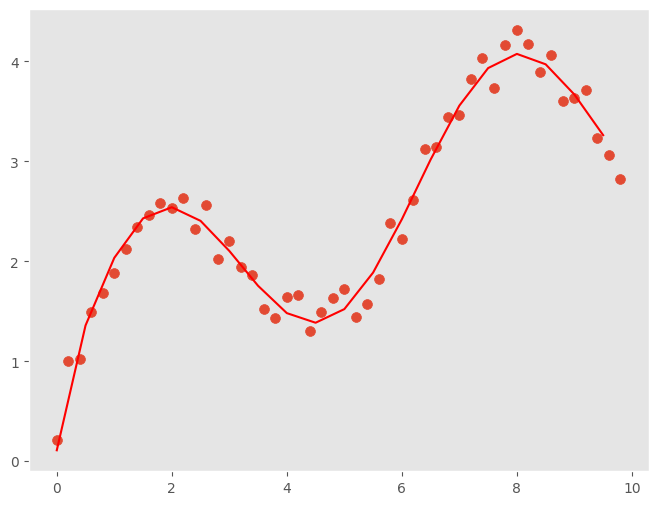

In [19]:
from sklearn.linear_model import LinearRegression as LR
reg_lr = LR()
plot_reg(X_reg3, y_reg, reg_lr, X_test3, dim=0)

# Масштабирование (Scaling)

Рассмотрим такую ситуацию: у вас есть данные о дороге с 2мя признаками: `длина участка дороги` и `толщина слоя асфальта`. Обе величины даются в одной метрике - метры. И нам нужно бинарно классифицировать качество дороги: `хорошая`,`плохая`.

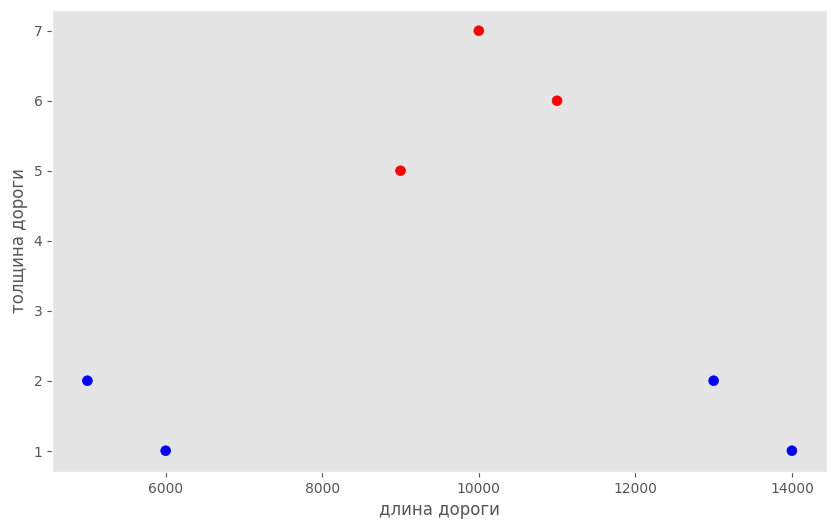

In [20]:
X = np.array([[10000, 7],[11000, 6],[9000, 5],[5000, 2],[6000, 1],[13000, 2],[14000, 1]])
y = np.array([1,1,1,0,0,0,0]) # 1 - хорошие, 0 - плохие
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=50, alpha=1)
plt.xlabel('длина дороги')
plt.ylabel('толщина дороги')
plt.grid()

Из логики нам будет очевидно, что первый признак практически бесполезен, а второй играет ключевую роль. Но, если запустить KNN или любой другой `метрический` алгоритм, мы получим обратную ситуацию, признак который в абсолюте больше - **важнее**, чем признак, который очень мало отличается.  

In [21]:
model = KNN(3)
model.fit(X,y)
X_bad = [[10000, 1]] 
y_pred = model.predict(X_bad)
X_new = np.vstack([X, X_bad])
y_new = np.hstack([y, y_pred])


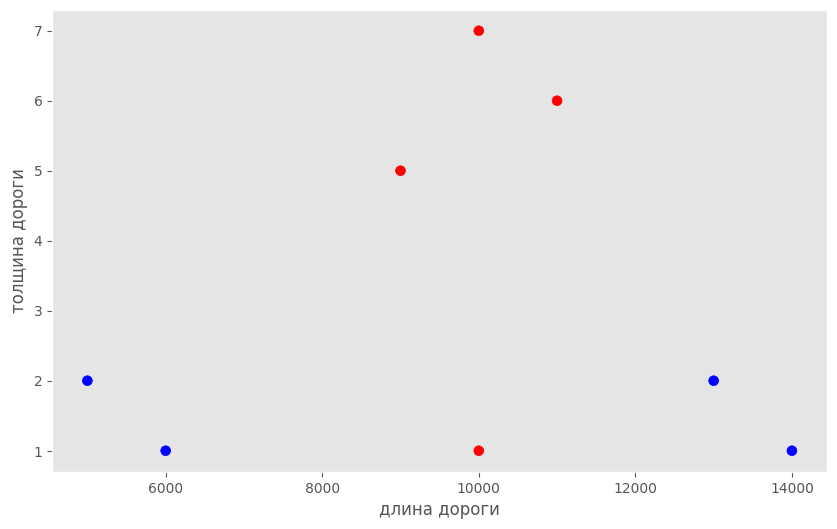

In [22]:
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, cmap='bwr', s=50, alpha=1)
plt.xlabel('длина дороги')
plt.ylabel('толщина дороги')
plt.grid()

Почему новая точка классифицировалась неправильно? Потому что, с точки зрения эвклидовой метрики, до `хороших` ей действительно `ближе`.

$$\rho((6000, 7), (10000, 1)) = \sqrt{(6000 - 10000)^2 + (7-1)^2} = \sqrt{6^2} << \rho((6000, 1), (10000, 1)) = \sqrt{4000^2 + (1-1)^2}$$

Чтобы справиться с этой проблемой важно `масштабировать` численные признаки, чтобы они были корректно сравнимы.

Есть разные подходы к масштабированию, например:
* Нормализация (MinMax Scaling) $$x^* = \frac{x-x_{min}}{x_{max} - x_{min}}$$
* Стандартизация (Standart Scaling) $$x^* = \frac{x-\mu}{\sigma}$$, где $\mu$ - среднее, а $\sigma$ - стандартное отклонение

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
stan = StandardScaler().fit(X)
norm = MinMaxScaler().fit(X)
X_st = stan.transform(X)
X_norm = norm.transform(X)

Метод `fit` подбирает параметры масштабирования, а метод `transform` непосредственно преобразует значения. 

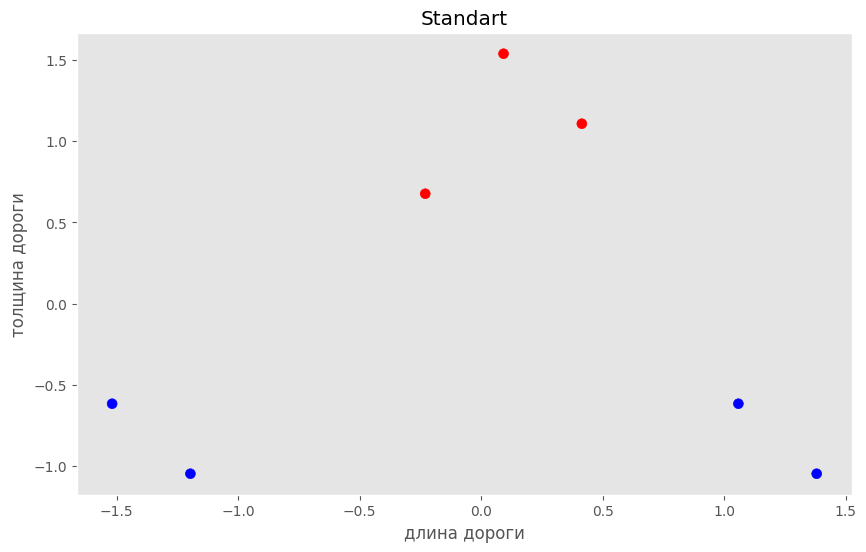

In [24]:
plt.scatter(X_st[:,0], X_st[:,1], c=y, cmap='bwr', s=50, alpha=1)
plt.title('Standart')
plt.xlabel('длина дороги')
plt.ylabel('толщина дороги')
plt.grid()

И вот теперь мы можем верно классифицировать данные, не забыв трансформировать точку, которую предсказываем

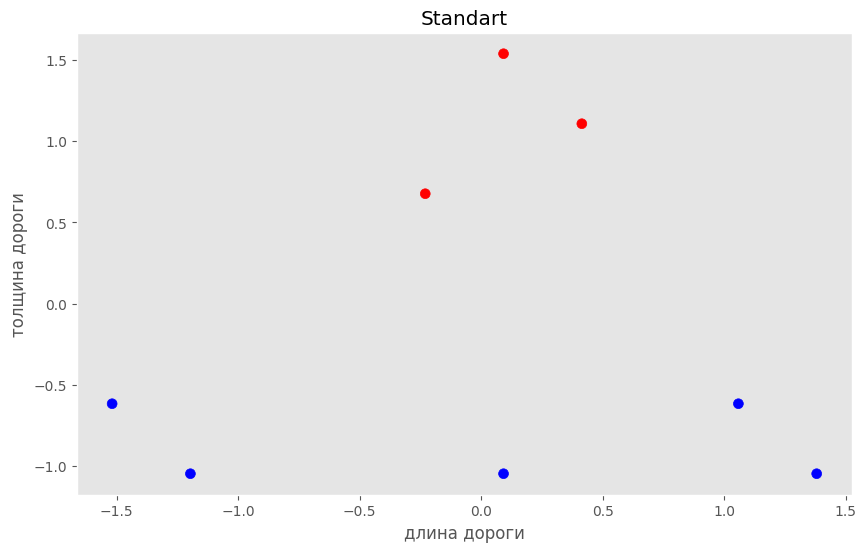

In [25]:
model = KNN(3)
model.fit(X_st,y)
X_bad = stan.transform([[10000, 1]]) 
y_pred = model.predict(X_bad)

X_new = np.vstack([X_st, X_bad])
y_new = np.hstack([y, y_pred])
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, cmap='bwr', s=50, alpha=1)
plt.title('Standart')
plt.xlabel('длина дороги')
plt.ylabel('толщина дороги')
plt.grid()

Интересный факт, что любые древесные алгоритмы: DecisionTree, RandomForest - не требуют масштабирования. Потому что они работают на пороговых правилах и все признаки у них остаются независимыми.

Резюме: Хороший паттерн думать о масштабировании - `всегда`. Потому что для метрических алгоритмов оно часто необходимо, а для деревьев оно ничего не портит.

Чтобы прочувствовать это на примере можно сходить по [ссылке](https://alexanderdyakonov.wordpress.com/2019/10/31/%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F/) и прочитать кусочек со слов "Полезным является иллюстрация, как ведут себя коэффициенты при регуляризации"

# Категориальные признаки

Окей, с числовыми признаками разобрались, но ведь доставать необходимую информацию нужно еще и из категориальных признаков. Как с ними можно работать?

## Label Encoding

Рассмотрим выборку UCI bank, в которой большая часть признаков – категориальные.

In [26]:
import pandas as pd
df = pd.read_csv('data/bank_train.csv')
labels = pd.read_csv('data/bank_train_target.csv', header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Мы не можем работать не с числовыми признаками, поэтому естественным решением такой проблемы было бы однозначное отображение каждого значения в уникальное число. Например для столбца job, преобразование admin. -> 0, blue-collar -> 1 и т.д.  
Эту простую операцию приходится делать часто, поэтому в модуле `preprocessing` библиотеки `sklearn` именно для этой задачи реализован класс `LabelEncoder`:

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()

categorical_columns = df.columns[df.dtypes == 'object'] #тип object характеризует признаки, которые нужно преобразовать
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


In [28]:
df.shape

(27595, 20)

**Обратите внимание**  
Основная проблема такого представления заключается в том, что числовой код создал евклидово представление для данных.  
К примеру, нами неявным образом была введена алгебра над значениями работы - мы можем вычесть работу клиента 1 из работы клиента 2.

In [29]:
df.loc[1].job - df.loc[2].job

-1.0

Конечно же, эта операция не имеет никакого смысла. Но именно на этом основаны метрики близости объектов, что делает бессмысленным применение метода ближайшего соседа на данных в таком виде. Аналогичным образом, применение линейных моделей может давать непредсказуемо плохой (или хороший) результат.

*Помните про различие порядковых (ordinal) и категориальных (categorial) признаков?*

In [30]:
clf_linear = LogisticRegression()
cross_val_score(clf_linear, df, labels).mean()

0.9091502083710816

Однако для древесных моделей `LabelEncoding` вполне сгодится.

Для того, чтобы мы смогли применять линейные модели на таких данных нам необходим другой метод, который называется One-Hot Encoding

## One-Hot Encoding

Предположим, что некоторый признак может принимать 10 разных значений. В этом случае one hot encoding подразумевает создание 10 признаков, все из которых равны нулю *за исключением одного*. На позицию, соответствующую численному значению признака мы помещаем 1:

In [31]:
df = pd.read_csv('data/bank_train.csv')
labels = pd.read_csv('data/bank_train_target.csv', header=None)
categorical_columns = df.columns[df.dtypes == 'object']
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [32]:
onehot_encoder = OneHotEncoder(sparse_output=False)

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.columns = [str(x) for x in encoded_categorical_columns.columns]
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
df = df.drop(columns=categorical_columns)

In [34]:
df = pd.concat([encoded_categorical_columns, df], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,26,901,1,999,0,1.4,94.465,-41.8,4.961,5228.1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46,208,2,999,0,1.4,93.444,-36.1,4.963,5228.1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49,131,5,999,0,1.4,94.465,-41.8,4.864,5228.1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,31,404,1,999,0,-2.9,92.469,-33.6,1.044,5076.2
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42,85,1,999,0,-0.1,93.200,-42.0,4.191,5195.8


In [35]:
df.shape

(27595, 63)

Мы получили 63 столбца - именно столько различных уникальных значений могут принимать категориальные столбцы исходной выборки. Преобразованные с помощью One-Hot Encoding данные начинают обретать смысл для линейной модели:

In [36]:
clf_linear = LogisticRegression()
cross_val_score(clf_linear, df, labels).mean()

0.9100199311469469

Проблема возникает когда, количество различных значений у категориального признака сильно возрастает. В этом случае `OneHotEncoding` станет очень затратным по памяти (даже если будем использовать разреженные таблицы).

## Хэширование признаков (Hashing trick)

Материал взят [отсюда](https://habr.com/ru/company/ods/blog/326418/)

С течением времени категориальные признаки могут принимать новых значений. Это затрудняет использование уже обученных моделей на новых данных. Кроме того, `LabelEncoder` подразумевает предварительный анализ всей выборки и хранение построенных отображений в памяти, что затрудняет работу в режиме больших данных.

Для решения этих проблем существует более простой подход к векторизации категориальных признаков, основанный на хэшировании, известный как hashing trick. 

Хэш-функции могут помочь нам в задаче поиска уникальных кодов для различных значений признака, к примеру:

In [37]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 12
high.school -> 13
illiterate -> 1


Представим, что у нас в выборке есть холостой студент, которому позвонили в понедельник, тогда его вектор признаков будет сформирован аналогично One-Hot Encoding, но в едином пространстве фиксированного размера для всех признаков:

In [38]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 23
marital=single -> 22
day_of_week=mon -> 4


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Стоит обратить внимание, что в этом примере хэшировались не только значения признаков, а пары **название признака + значение признака**. Это необходимо, чтобы разделить одинаковые значения разных признаков между собой, к примеру:

In [39]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Может ли произойти коллизия хэш-функции, то есть совпадение кодов для двух разных значений? Нетрудно доказать, что при достаточном размере пространства хэширования это происходит редко, но даже в тех случаях, когда это происходит, это не будет приводить к существенному ухудшению качества классификации или регрессии.

Возможно, вы спросите: "а что за хрень вообще происходит?", и покажется, что при хэшировании признаков страдает здравый смысл. Возможно, но эта эвристика – по сути, единственный подход к тому, чтобы работать с категориальными признаками, у которых много уникальных значений. Более того, эта техника себя хорошо зарекомендовала по результатами на практике. Подробней про хэширование признаков (learning to hash) можно почитать в [этом](https://arxiv.org/abs/1509.05472) обзоре, а также в [материалах](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf) Евгения Соколова.

# Blending

Сейчас мы познакомимся с внутренним устройством классификаторов и попытаемся сделать свой смешанный классификатор.

Часто на практике оказывается возможным увеличить качество предсказания путем смешивания разных моделей. Это происходит за счет того, что разные модели могут хранить в себе разные скрытые зависимости от данных, которые могут вместе дать синергию.

Посмотрим на наш небольшой класс классификатора.

In [40]:
from sklearn.base import BaseEstimator, ClassifierMixin
class BlendClassifier(BaseEstimator, ClassifierMixin):# предок класса всех классификаторов
    def __init__(self, clf1, clf2, alpha=0.5):
        self.clf1 = clf1 
        self.clf2 = clf2
        self.alpha = alpha #параметр смешивания

    def fit(self, X, y): #обучаем классификатор
        self.X_ = X
        self.y_ = y 
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        return self

    def predict(self, X): #возвращаем значения
        predict1 = self.clf1.predict(X)
        predict2 = self.clf2.predict(X)
        
        return np.round(predict1 * self.alpha + predict2 * (1 - self.alpha))

    def predict_proba(self, X): #возвращаем вероятности
        predict1 = self.clf1.predict_proba(X)
        predict2 = self.clf2.predict_proba(X)
        
        return predict1 * self.alpha + predict2 * (1 - self.alpha)

In [48]:
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.datasets import load_iris

np.random.seed(1234)
iris_x, iris_y = load_iris(return_X_y=True)

clf1 = SGD(loss = 'log_loss')
print(cross_val_score(clf1, iris_x, iris_y, scoring='accuracy').mean())
clf2 = DTC(max_depth=1)
print(cross_val_score(clf2, iris_x, iris_y, scoring='accuracy').mean())


clf = BlendClassifier(
        clf1 = SGD(loss = 'log_loss'), 
        clf2 = DTC(max_depth=1)
    )
print(cross_val_score(clf, iris_x, iris_y).mean())

0.74
0.6666666666666666
0.7933333333333333
